In [224]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
%autoreload 2


ages = np.array([22,24,25,26,26,27,29,30,31,32,32,32,33,35,36,36,38,38])
edgeFeatures = np.loadtxt('combinedFeaturesForPython.txt', delimiter="\t")
degreeFeatures = np.loadtxt('combinedDegreeFeaturesForPython.txt', delimiter="\t")
print edgeFeatures[12,700]
print np.size(ages)
# plt.imshow(features[:2,:].astype('uint8'),extent=[0,4095,0,18], aspect='auto')




0.0041843
18


(18L, 90L)
(18L, 2L)


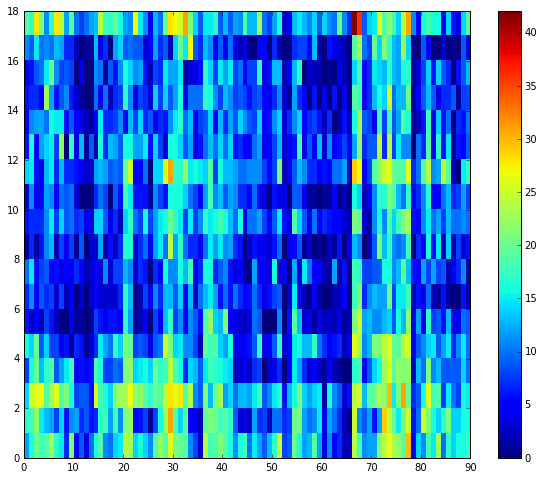

In [106]:
sel = VarianceThreshold(0.01)
thresholdedFeatures = sel.fit_transform(degreeFeatures)
print np.shape(thresholdedFeatures)
X_new = SelectKBest(f_regression, k=2).fit_transform(thresholdedFeatures, ages)
print np.shape(X_new)
plt.imshow(thresholdedFeatures,extent=[0,90,0,18], aspect='auto',vmin=0, vmax=np.max(thresholdedFeatures))
plt.colorbar()

In [107]:
# Stability selection
from sklearn.linear_model import RandomizedLasso
 
#using the Boston housing data. 
#Data gets scaled automatically by sklearn's implementation
 
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(degreeFeatures, ages)
print np.argsort(rlasso.scores_)[-20:]
print np.shape(rlasso.scores_)

[ 1 37 67 46 60 20 53 22 54 89  7 27 47 64 21 38 75 87 79  4]
(90L,)


[68 47 38 21  7 46 25 67  4 79 87 22  1 27 89 54 75 64 29 69 53 20 56 60]
(90L,)
4


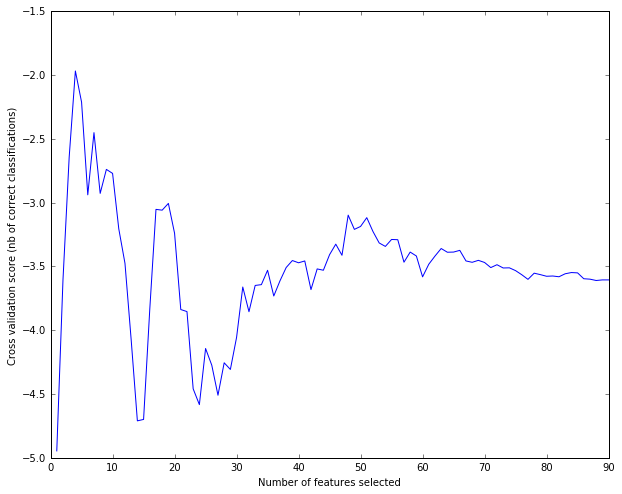

In [166]:
# Recursive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFECV(lr, step=1, cv=17)
rfe.fit(degreeFeatures,ages)
print np.argsort(rfe.ranking_)[:24]
print np.shape(rfe.ranking_)
print rfe.n_features_
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

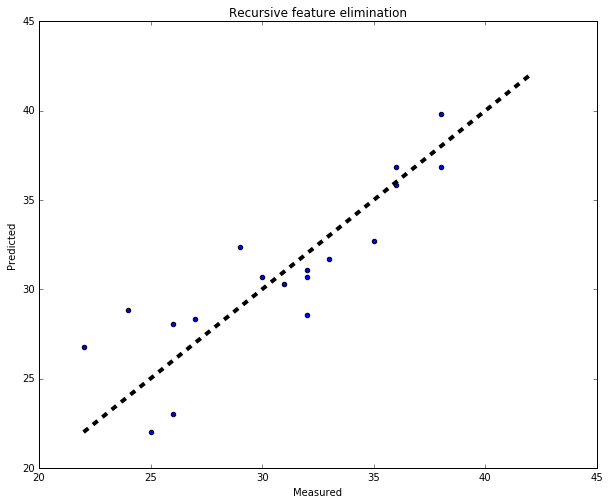

10.4572370036


In [240]:
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.feature_selection import f_regression

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, degreeFeatures[:,np.argsort(rfe.ranking_)[:rfe.n_features_]],ages, cv=17)

F, Pval = f_regression(degreeFeatures[:,np.argsort(rfe.ranking_)[:rfe.n_features_]],ages, center=True)

fig, ax = plt.subplots()
plt.title('Recursive feature elimination')
ax.scatter(ages, predicted)
ax.plot([22, 42], [22, 42], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print np.linalg.norm(ages- predicted,2)


[ 0.00443033  0.00390093  0.01980393  0.01334301  0.00682693  0.0033128
  0.0168594   0.00390381  0.00318403  0.00273225  0.00207145  0.00187642
  0.00193438  0.01731745  0.00373072  0.00682622  0.00198858  0.00541077
  0.00601215  0.01203811  0.0943619   0.01703345  0.0050786   0.02746226
  0.00117227  0.00644436  0.00345929  0.01920647  0.00719608  0.01106179
  0.00601748  0.00162635  0.00383806  0.00290021  0.00275907  0.00442044
  0.02459158  0.01294154  0.09345698  0.00302685  0.00487989  0.01040969
  0.00212385  0.00975237  0.00569042  0.00130062  0.00269211  0.00525542
  0.00094171  0.00188671  0.00166393  0.00203897  0.00680984  0.00564008
  0.16054695  0.00287227  0.00335688  0.00234594  0.00403921  0.0028522
  0.00155437  0.00216376  0.00162736  0.00156314  0.01112023  0.0007373
  0.00256428  0.00414373  0.00547985  0.01536365  0.0055649   0.00258262
  0.00968215  0.0061866   0.00486387  0.01200122  0.00281409  0.00350057
  0.03295668  0.04118302  0.00322872  0.00213501  0.00

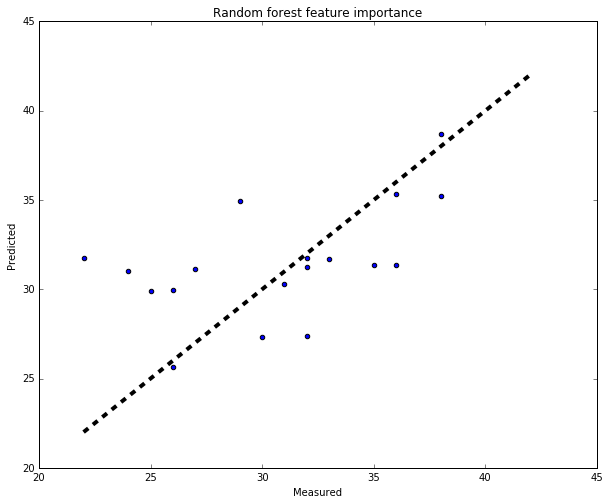

17.6175986472


In [257]:
#Random forest feature importance
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10000)
rf.fit(degreeFeatures, ages)
print rf.feature_importances_

predicted = cross_val_predict(lr, degreeFeatures[:,np.argsort(rf.feature_importances_)[:-4]],ages, cv=17)

fig, ax = plt.subplots()
plt.title('Random forest feature importance')
ax.scatter(ages, predicted)
ax.plot([22, 42], [22, 42], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print np.linalg.norm(ages- predicted,2)

In [258]:
print np.argsort(rf.feature_importances_)[-10:]
print np.sort(rf.feature_importances_)[-10:]

[27  2 36 23 78 79 87 38 20 54]
[ 0.01920647  0.01980393  0.02459158  0.02746226  0.03295668  0.04118302
  0.0578197   0.09345698  0.0943619   0.16054695]


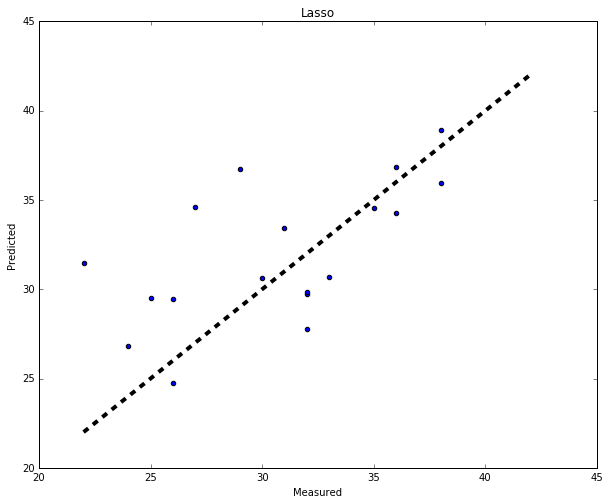

17
17.2221155078


In [243]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
lr2 = linear_model.LinearRegression()
predictedAge = np.zeros(18)
kf = KFold(18, n_folds=18)
lmlasso = Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)
for train_index, test_index in kf:
    trainFold = degreeFeatures[train_index,:]
    trainFoldLable = ages[train_index]
    testFold = degreeFeatures[test_index,:]
    testFoldLable = ages[test_index]
    
    lmlasso.fit(trainFold, trainFoldLable)
    model = SelectFromModel(lmlasso, prefit=True)
    degreeFeatures_new = model.transform(trainFold)
    degreeFeatures_new_test = model.transform(testFold) 
    lr2.fit(degreeFeatures_new,trainFoldLable)
    predictedAge[test_index] = lr2.predict(degreeFeatures_new_test)
fig, ax = plt.subplots()
plt.title('Lasso')
ax.scatter(ages, predictedAge)
ax.plot([22, 42], [22, 42], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print np.size(degreeFeatures_new_test)
print np.linalg.norm(ages- predictedAge,2)

In [213]:
predictedAge = np.zeros(18)
print predictedAge

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [218]:
degreeFeatures[0,:]

array([ 19.,  17.,  28.,  21.,  11.,  17.,  28.,  24.,  12.,  19.,  10.,
         8.,  10.,  12.,  13.,  24.,  18.,  17.,  20.,  16.,  12.,  11.,
        27.,  15.,  11.,   5.,  13.,  10.,  20.,  28.,  27.,  25.,  31.,
        21.,  14.,   9.,  15.,  15.,  17.,   9.,  13.,   9.,  12.,  11.,
        19.,  13.,  13.,  23.,  10.,   8.,  12.,  16.,   3.,   5.,  13.,
        15.,  13.,  11.,  14.,   9.,  14.,  11.,  10.,  20.,  11.,   7.,
        42.,  36.,   9.,  14.,  15.,  26.,  19.,  22.,  18.,  14.,  24.,
        31.,  11.,   5.,  16.,  18.,  16.,  16.,   5.,  14.,   6.,   4.,
        14.,  19.])

In [227]:
lr.predict(testFold)

ValueError: shapes (1,90) and (16,) not aligned: 90 (dim 1) != 16 (dim 0)